# Encoder

### Módulos

In [ ]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [ ]:
%%capture
!pip install huggingface_hub
!pip install bitsandbytes
!pip install faiss-cpu
!pip install scikit-learn

### Librerías

In [ ]:
import os
import pickle
import torch
import numpy as np
import faiss
import re
import transformers
import bitsandbytes as bnb
import time
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

from huggingface_hub import login
from collections import defaultdict

from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    BertTokenizer,
    BertModel
)

### Constantes

In [ ]:
#BERT_MODEL = "base"
BERT_MODEL = "med"
BERT_EMBEDDINGS = "bert_embeddings"
TRAIN_QUESTION_EMBEDDINGS = "train_questions_embeddings"
EVAL_QUESTION_EMBEDDINGS = "eval_questions_embeddings"
FAISS_INDEX_FILENAME = "faiss_index"

In [ ]:
# Semilla para reproducibilidad
torch.manual_seed(50)
np.random.seed(50)

In [ ]:
# Configuración de device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo disponible: {device}")

Dispositivo disponible: cuda


### Carga del modelo usando HuggingFace

In [ ]:
# Cargar modelo BERT
if BERT_MODEL == "base":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained("bert-base-uncased")
else:
    tokenizer = BertTokenizer.from_pretrained("ncbi/MedCPT-Article-Encoder")
    model = BertModel.from_pretrained("ncbi/MedCPT-Article-Encoder")

model = model.to(device)
model.eval()
print("Modelo BERT cargado exitosamente")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Modelo BERT cargado exitosamente


In [ ]:
# Depuración: Ver qué archivos se descargaron
all_files_found = []
for root, dirs, files in os.walk("Data_Sources"):
    for file in files:
        if file.endswith('.txt'):
            all_files_found.append(file)

# Mostrar estadísticas
print(f"Total de archivos .txt encontrados: {len(all_files_found)}")
if all_files_found:
    print("\nPrimeros 10 nombres de archivos:")
    for f in all_files_found[:10]:
        print(f"  - {f}")
    print("\nÚltimos 10 nombres de archivos:")
    for f in all_files_found[-10:]:
        print(f"  - {f}")

    # Contar archivos con _accumulated_section
    files_with_section = [f for f in all_files_found if '_accumulated_section' in f]
    files_without_section = [f for f in all_files_found if '_accumulated_section' not in f]

    print(f"\nArchivos SIN '_accumulated_section' (médicos): {len(files_without_section)}")
    print(f"Archivos CON '_accumulated_section' (sencillos): {len(files_with_section)}")

    if files_with_section:
        print("\nEjemplos de archivos sencillos:")
        for f in files_with_section[:5]:
            print(f"  - {f}")
    else:
        print("\n⚠ NO se encontraron archivos con '_accumulated_section'")
        print("Esto significa que los archivos sencillos pueden tener un nombre diferente.")
        print("\nTodos los nombres únicos de archivos (primeros 20):")
        unique_names = sorted(set(all_files_found))[:20]
        for f in unique_names:
            print(f"  - {f}")
print("\n" + "="*60 + "\n")


Total de archivos .txt encontrados: 0




### Carga de Datos

In [ ]:
# Cargar archivos .txt por pares desde repositorio de GitHub (Data Sources)
# 4 laboratorios: ClinicalTrials.gov, Cochrane, Pfizer, Trial Summaries
# Cada uno con carpetas: test y train
# Cada carpeta tiene pares: médico (clínico) y sencillo (plano)
REPO_URL = "https://github.com/feliperussi/bridging-the-gap-in-health-literacy"
BRANCH = "main"  # Cambia a "master" si es necesario
BASE_PATH = "data_collection_and_processing/Data Sources"

# Los 4 laboratorios/fuentes
LABORATORIOS = {
    "ClinicalTrials.gov": "ClinicalTrials.gov",
    "Cochrane": "Cochrane",
    "Pfizer": "Pfizer",
    "Trial Summaries": "Trial Summaries"
}

# Función para listar archivos en una carpeta usando GitHub API
def list_files_in_folder(folder_path):
    """
    Lista archivos en una carpeta del repositorio usando GitHub API.
    Retorna lista de tuplas (nombre_archivo, url_download)
    """
    api_url = f"https://api.github.com/repos/feliperussi/bridging-the-gap-in-health-literacy/contents/{folder_path}"

    try:
        response = requests.get(api_url)
        response.raise_for_status()
        items = response.json()

        # Si es una lista de archivos
        if isinstance(items, list):
            result = []
            for item in items:
                if item['type'] == 'file' and item['name'].endswith('.txt'):
                    result.append((item['name'], item['download_url']))
                elif item['type'] == 'dir':
                    # Recursivamente listar archivos en subdirectorios
                    subfolder_path = f"{folder_path}/{item['name']}"
                    sub_files = list_files_in_folder(subfolder_path)
                    result.extend(sub_files)
            return result
        return []
    except Exception as e:
        print(f"Error al listar archivos en {folder_path}: {e}")
        return []

# Función para descargar un archivo
def download_file(download_url, local_path):
    """
    Descarga un archivo desde GitHub y lo guarda localmente.
    """
    # Crear directorio si no existe
    local_dir = os.path.dirname(local_path)
    if local_dir and not os.path.exists(local_dir):
        os.makedirs(local_dir, exist_ok=True)

    try:
        response = requests.get(download_url)
        response.raise_for_status()

        # Guardar el archivo localmente
        with open(local_path, 'w', encoding='utf-8') as f:
            f.write(response.text)
        return True
    except Exception as e:
        print(f"✗ Error al descargar {local_path}: {e}")
        return False

# Función para identificar pares de archivos (médico y sencillo)
def identify_pairs(files):
    """
    Identifica pares de archivos: texto médico/clínico y texto sencillo/plano.
    - Archivos con '_accumulated_section' son versiones sencillas/planas
    - Archivos sin ese sufijo son los médicos/clínicos
    """
    pairs = []
    base_files = {}  # {base_name: {'medico': file, 'sencillos': [files]}}

    for filename, url in files:
        if '_accumulated_section' in filename:
            # Es un archivo sencillo/plano
            base_name = filename.split('_accumulated_section')[0]
            if base_name not in base_files:
                base_files[base_name] = {'medico': None, 'sencillos': []}
            base_files[base_name]['sencillos'].append((filename, url))
        else:
            # Es un archivo médico/clínico
            base_name = filename.replace('.txt', '')
            if base_name not in base_files:
                base_files[base_name] = {'medico': None, 'sencillos': []}
            base_files[base_name]['medico'] = (filename, url)

    # Crear pares
    for base_name, files_dict in base_files.items():
        if files_dict['medico']:
            medico_file = files_dict['medico']
            # Si hay archivos sencillos, crear pares con cada uno
            if files_dict['sencillos']:
                for sencillo_file in files_dict['sencillos']:
                    pairs.append({
                        'medico': medico_file,
                        'sencillo': sencillo_file,
                        'base_name': base_name
                    })
            else:
                # Solo archivo médico, sin par sencillo
                pairs.append({
                    'medico': medico_file,
                    'sencillo': None,
                    'base_name': base_name
                })

    return pairs

# Construir rutas de carpetas para cada laboratorio (test y train)
print("=== Configurando estructura de carpetas ===\n")
folders_to_process = []

for lab_name, lab_path in LABORATORIOS.items():
    # Para cada laboratorio, buscar carpetas test y train
    lab_full_path = f"{BASE_PATH}/{lab_path}"

    # Intentar diferentes estructuras según el laboratorio
    if lab_name == "Pfizer":
        # Pfizer tiene estructura: test/pls, train/pls (no tiene non_pls)
        folders_to_process.extend([
            f"{lab_full_path}/test/pls",
            f"{lab_full_path}/train/pls",
        ])
    elif lab_name == "Cochrane":
        # Cochrane tiene estructura: test/pls, test/non_pls, train/pls, train/non_pls
        folders_to_process.extend([
            f"{lab_full_path}/test/pls",
            f"{lab_full_path}/test/non_pls",
            f"{lab_full_path}/train/pls",
            f"{lab_full_path}/train/non_pls",
        ])
    elif lab_name == "ClinicalTrials.gov":
        # ClinicalTrials.gov tiene estructura directa: test, train
        folders_to_process.extend([
            f"{lab_full_path}/test",
            f"{lab_full_path}/train",
        ])
    elif lab_name == "Trial Summaries":
        # Trial Summaries tiene estructura diferente: med, alx, etc. (no test/train)
        folders_to_process.extend([
            f"{lab_full_path}/med",
            f"{lab_full_path}/alx",
        ])

print(f"Carpetas a procesar: {len(folders_to_process)}\n")

# Listar archivos en todas las carpetas
print("=== Listando archivos desde Data Sources ===\n")
all_files_by_folder = {}

for folder in folders_to_process:
    print(f"Listando archivos en: {folder}")
    files = list_files_in_folder(folder)
    if files:
        all_files_by_folder[folder] = files
        print(f"  ✓ Encontrados {len(files)} archivos .txt")
    else:
        print(f"  ⚠ No se encontraron archivos .txt")
    print()

print(f"Total de carpetas con archivos: {len(all_files_by_folder)}\n")

# Identificar y descargar pares por carpeta
print("=== Identificando pares y descargando archivos ===\n")
total_pairs = 0
total_downloaded = 0

for folder_path, files in all_files_by_folder.items():
    # Identificar pares en esta carpeta
    pairs = identify_pairs(files)
    total_pairs += len(pairs)

    # Crear ruta local manteniendo estructura
    folder_key = folder_path.replace(BASE_PATH + '/', '')
    print(f"\n📁 {folder_key}: {len(pairs)} pares identificados")

    # Descargar archivos de cada par
    for pair in tqdm(pairs, desc=f"  Descargando {folder_key.split('/')[-1]}", leave=False):
        # Descargar archivo médico
        if pair['medico']:
            filename, url = pair['medico']
            local_path = os.path.join("Data_Sources", folder_key, filename)
            if download_file(url, local_path):
                total_downloaded += 1

        # Descargar archivo sencillo
        if pair['sencillo']:
            filename, url = pair['sencillo']
            local_path = os.path.join("Data_Sources", folder_key, filename)
            if download_file(url, local_path):
                total_downloaded += 1

print(f"\n{'='*60}")
print(f"✓ Proceso completado:")
print(f"  - Total de pares identificados: {total_pairs}")
print(f"  - Total de archivos descargados: {total_downloaded}")
print(f"{'='*60}")


=== Configurando estructura de carpetas ===

Carpetas a procesar: 10

=== Listando archivos desde Data Sources ===

Listando archivos en: data_collection_and_processing/Data Sources/ClinicalTrials.gov/test
  ✓ Encontrados 129 archivos .txt

Listando archivos en: data_collection_and_processing/Data Sources/ClinicalTrials.gov/train
  ✓ Encontrados 622 archivos .txt

Listando archivos en: data_collection_and_processing/Data Sources/Cochrane/test/pls
  ✓ Encontrados 1000 archivos .txt

Listando archivos en: data_collection_and_processing/Data Sources/Cochrane/test/non_pls
  ✓ Encontrados 1000 archivos .txt

Listando archivos en: data_collection_and_processing/Data Sources/Cochrane/train/pls
  ✓ Encontrados 1000 archivos .txt

Listando archivos en: data_collection_and_processing/Data Sources/Cochrane/train/non_pls
  ✓ Encontrados 1000 archivos .txt

Listando archivos en: data_collection_and_processing/Data Sources/Pfizer/test/pls
  ✓ Encontrados 116 archivos .txt

Listando archivos en: data


📁 ClinicalTrials.gov/train: 81 pares identificados



📁 Cochrane/test/pls: 379 pares identificados



📁 Cochrane/test/non_pls: 310 pares identificados



📁 Cochrane/train/pls: 339 pares identificados



📁 Cochrane/train/non_pls: 307 pares identificados



📁 Pfizer/test/pls: 26 pares identificados



📁 Pfizer/train/pls: 106 pares identificados



📁 Trial Summaries/med: 978 pares identificados



📁 Trial Summaries/alx: 56 pares identificados



✓ Proceso completado:
  - Total de pares identificados: 2603
  - Total de archivos descargados: 2603


In [ ]:
# Explorar estructura de archivos .txt descargados
# Directorio base donde se descargaron los archivos
base_dir = "Data_Sources"

# Organizar archivos por laboratorio y tipo
txt_structure = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

if os.path.exists(base_dir):
    # Recorrer todas las carpetas
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                # Extraer estructura: Data_Sources/Laboratorio/train|test/...
                parts = Path(file_path).parts
                if len(parts) >= 3:
                    lab = parts[1]  # Laboratorio
                    split_type = parts[2]  # train o test
                    # Solo incluir carpetas, no el nombre del archivo
                    subfolder = '/'.join(parts[3:-1]) if len(parts) > 3 else ''
                    txt_structure[lab][split_type][subfolder].append(file)

    # Mostrar estructura (solo resumen, sin listar archivos individuales)
    print("=== Estructura de archivos .txt ===\n")
    for lab in sorted(txt_structure.keys()):
        print(f" {lab}:")
        for split_type in sorted(txt_structure[lab].keys()):
            print(f"  ├─ {split_type}:")
            for subfolder, files in txt_structure[lab][split_type].items():
                if subfolder:
                    print(f"  │  ├─ {subfolder}: {len(files)} archivos")
                else:
                    print(f"  │  └─ {len(files)} archivos")
            print()

    # Contar totales
    total_files = sum(len(files) for lab_dict in txt_structure.values()
                     for split_dict in lab_dict.values()
                     for files in split_dict.values())

    print(f"\n{'='*60}")
    print(f"Total de archivos .txt: {total_files}")
    print(f"{'-'*60}")

    # Mostrar algunos ejemplos de pares
    print("\n=== Ejemplos de pares de archivos ===\n")
    for lab in sorted(txt_structure.keys()):
        for split_type in sorted(txt_structure[lab].keys()):
            for subfolder, files in txt_structure[lab][split_type].items():
                if files:
                    # Buscar pares (archivos con y sin _accumulated_section)
                    base_files = {}
                    for file in files:
                        if '_accumulated_section' in file:
                            base = file.split('_accumulated_section')[0]
                            if base not in base_files:
                                base_files[base] = {'medico': None, 'sencillos': []}
                            base_files[base]['sencillos'].append(file)
                        else:
                            base = file.replace('.txt', '')
                            if base not in base_files:
                                base_files[base] = {'medico': None, 'sencillos': []}
                            base_files[base]['medico'] = file

                    # Mostrar algunos pares
                    pairs_found = sum(1 for bf in base_files.values()
                                     if bf['medico'] and bf['sencillos'])
                    if pairs_found > 0:
                        print(f"{lab}/{split_type}/{subfolder}: {pairs_found} pares encontrados")
                        # Mostrar primer par como ejemplo
                        for base, files_dict in list(base_files.items())[:1]:
                            if files_dict['medico'] and files_dict['sencillos']:
                                print(f"  Ejemplo par:")
                                print(f"    Médico: {files_dict['medico']}")
                                print(f"    Sencillo: {files_dict['sencillos'][0]}")
                        break
else:
    print(f"⚠ El directorio {base_dir} no existe.")

=== Estructura de archivos .txt ===

 ClinicalTrials.gov:
  ├─ test:
  │  └─ 21 archivos

  ├─ train:
  │  └─ 81 archivos

 Cochrane:
  ├─ test:
  │  ├─ pls: 379 archivos
  │  ├─ non_pls: 310 archivos

  ├─ train:
  │  ├─ pls: 339 archivos
  │  ├─ non_pls: 307 archivos

 Pfizer:
  ├─ test:
  │  ├─ pls: 26 archivos

  ├─ train:
  │  ├─ pls: 106 archivos

 Trial Summaries:
  ├─ alx:
  │  └─ 56 archivos

  ├─ med:
  │  └─ 978 archivos


Total de archivos .txt: 2603
------------------------------------------------------------

=== Ejemplos de pares de archivos ===



### Revisión de máxima longitud de tokens

Tokenizando sencillos: 100%|██████████| 1344/1344 [00:14<00:00, 95.31it/s]


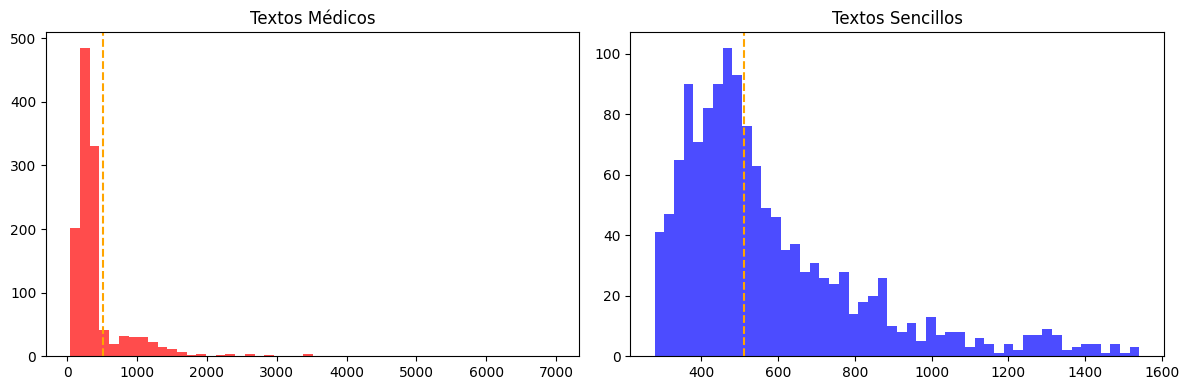

Total: 2603 textos (1259 médicos, 1344 sencillos)


In [ ]:
# Cargar y preparar datos para clasificador médico/sencillo (VERSIÓN CORREGIDA)
textos_medicos, textos_sencillos = [], []

for root, dirs, files in os.walk("Data_Sources"):
    for file in files:
        if file.endswith('.txt'):
            try:
                with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                    content = f.read().strip()
                    if content:
                        # Archivos sencillos tienen estos patrones: -pls.txt, -abstract.txt, _section[numero].txt
                        is_sencillo = (
                            '-pls.txt' in file or
                            '-abstract.txt' in file or
                            '_section' in file
                        )
                        if is_sencillo:
                            textos_sencillos.append(content)
                        else:
                            textos_medicos.append(content)
            except: pass

# Analizar longitudes de tokens
token_lengths_medicos = [tokenizer(t, truncation=False, return_tensors='pt')["input_ids"].shape[1]
                         for t in tqdm(textos_medicos, desc="Tokenizando médicos")]
token_lengths_sencillos = [tokenizer(t, truncation=False, return_tensors='pt')["input_ids"].shape[1]
                           for t in tqdm(textos_sencillos, desc="Tokenizando sencillos")]

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(token_lengths_medicos, bins=50, alpha=0.7, color='red')
axes[0].axvline(512, color='orange', linestyle='--')
axes[0].set_title('Textos Médicos')
axes[1].hist(token_lengths_sencillos, bins=50, alpha=0.7, color='blue')
axes[1].axvline(512, color='orange', linestyle='--')
axes[1].set_title('Textos Sencillos')
plt.tight_layout()
plt.show()

# Preparar datos para clasificador
X_textos = textos_medicos + textos_sencillos
y_labels = [0] * len(textos_medicos) + [1] * len(textos_sencillos)
print(f"Total: {len(X_textos)} textos ({len(textos_medicos)} médicos, {len(textos_sencillos)} sencillos)")


In [ ]:
def load_file(filename):
  file = []

  if os.path.exists(filename):
    with open(filename, "rb") as fp:   # Unpickling
      file = pickle.load(fp)

  return file

In [ ]:
def save_file(filename, file):
  with open(filename, "wb") as fp:   #Pickling
    pickle.dump(file, fp)

### Generación de embeddings de los extractos

Con base en la distribución anterior, se observan diferencias significativas entre los textos médicos y los textos sencillos:

- **Textos Sencillos**: Presentan una distribución más concentrada, con el pico alrededor de 500 tokens. La mayoría de estos textos se encuentran cerca del límite de 512 tokens del modelo BERT, lo que indica que están bien adaptados a esta longitud máxima.

- **Textos Médicos**: Muestran una distribución muy sesgada, con una gran concentración de textos muy cortos (pico inicial) pero también una cola larga que se extiende hasta aproximadamente 7000 tokens. Esto significa que una proporción considerable de textos médicos excederá el límite de 512 tokens y requerirá truncamiento.

A pesar de estas diferencias, el modelo BERT con truncamiento a 512 tokens sigue siendo adecuado para este conjunto de datos, ya que captura la información principal de la mayoría de los textos. El truncamiento afectará principalmente a los textos médicos más largos, pero el uso del token `[CLS]` para generar embeddings permite obtener una representación global del documento incluso cuando se trunca.

In [ ]:
# Calcular embeddings para clasificador médico/sencillo
embeddings = load_file(BERT_EMBEDDINGS)

if not embeddings:
  embeddings = []
  for texto in tqdm(X_textos, desc="Calculando embeddings"):
      encoded_input = tokenizer(
        texto,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512
      )
      encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

      with torch.no_grad():
        output = model(**encoded_input).last_hidden_state[0,0]

      output = output.cpu().numpy()
      normalized_output = output / np.linalg.norm(output)
      embeddings.append(normalized_output)

  save_file(BERT_EMBEDDINGS, embeddings)

# Convertir a arrays numpy para el clasificador
X_embeddings = np.array(embeddings, dtype='float32')
print(f"Embeddings calculados: {X_embeddings.shape}")

Calculando embeddings: 100%|██████████| 2603/2603 [01:21<00:00, 32.11it/s]

Embeddings calculados: (2603, 768)


In [ ]:
len(embeddings)

2603

## Entrenamiento del Clasificador

Accuracy: 0.9904

Classification Report:
              precision    recall  f1-score   support

      Médico       1.00      0.98      0.99       252
    Sencillo       0.99      1.00      0.99       269

    accuracy                           0.99       521
   macro avg       0.99      0.99      0.99       521
weighted avg       0.99      0.99      0.99       521



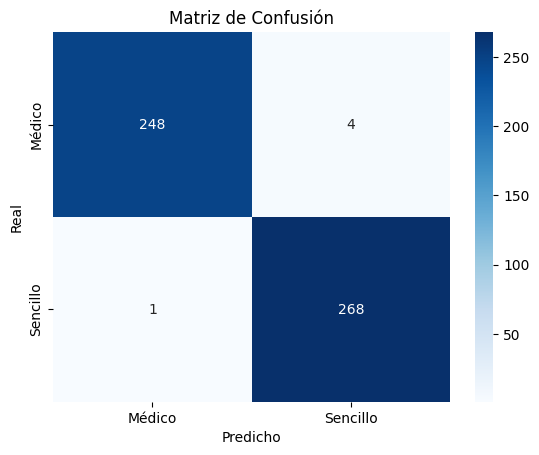


Modelo guardado exitosamente


In [ ]:
# Dividir datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y_labels, test_size=0.2, random_state=50, stratify=y_labels
)

# Entrenar clasificador
clf = LogisticRegression(random_state=50, max_iter=1000)
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Médico', 'Sencillo']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Médico', 'Sencillo'],
            yticklabels=['Médico', 'Sencillo'])
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()

# Guardar modelo
save_file("clasificador_medico_sencillo.pkl", clf)
print("\nModelo guardado exitosamente")
